# Lab 3 — recommender systems

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

from operator import itemgetter

%matplotlib inline
plt.style.use("ggplot")

In [2]:
def print_state(i , modulo, length) :
    
    if (i % modulo == 0):
        print("\r", 100*i/length, " %", end="")

What does the data look like?

In [2]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


In [3]:
# DEFINE THE FOLLOWING CONSTANTS

MOVIE = 0
USER = 1
TIMESTAMP = 2
RATING = 3

In [4]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

### 3.4 Basic statistics

##### We first create the list of all users and the list of all movies

In [5]:
user_list = data.map(itemgetter("userId")).collect()
movie_list = data.map(itemgetter("movieId")).collect()

###### We use the function np.unique with the parameter [return_counts = True] to obtain  the number of ratings for each unique user/film

In [6]:
unique_users, nb_rating_foreach_user = np.unique(user_list, return_counts = True)

unique_movies, nb_rating_foreach_movie = np.unique(movie_list, return_counts = True)

In [7]:
print("there are", len(unique_users), " differents users")
print("there are", len(unique_movies)," differents movies")

there are 138493  differents users
there are 26744  differents movies


---

We define a sorted_plot function to answer the question :

In [8]:
def sorted_plot(data, x_label, bins = 200):

    # ========== Plot Parameters ==========

    plt.figure(figsize=(11,11))
    
    forX = x_label + " (ids do not match anymore because of the sort)"
    forY = "number of ratings"
    forTitle = "Graph representing the number of ratings per " + x_label + " (sorted)"
    
    plt.xlabel(forX, fontsize = 15)
    plt.ylabel(forY, fontsize = 15)
    plt.title(forTitle, fontsize = 18)
    
    plt.plot(sorted(data))

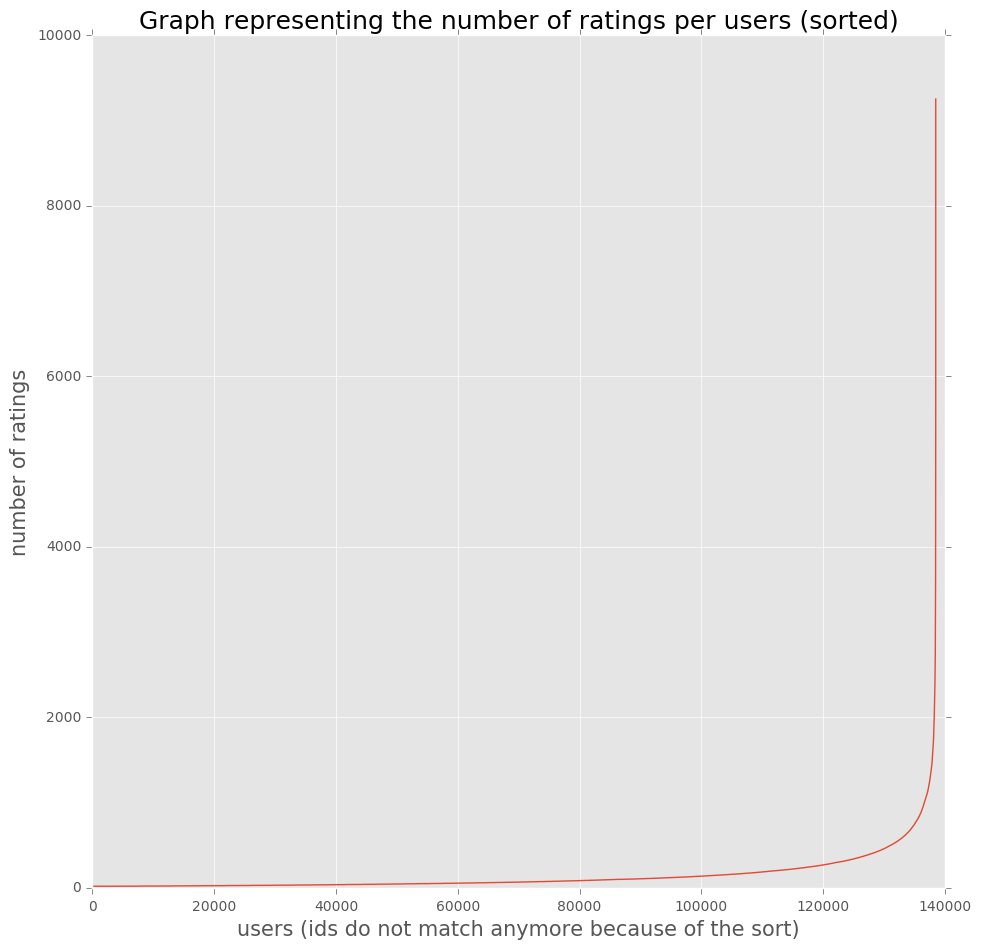

In [9]:
sorted_plot(nb_rating_foreach_user, "users")

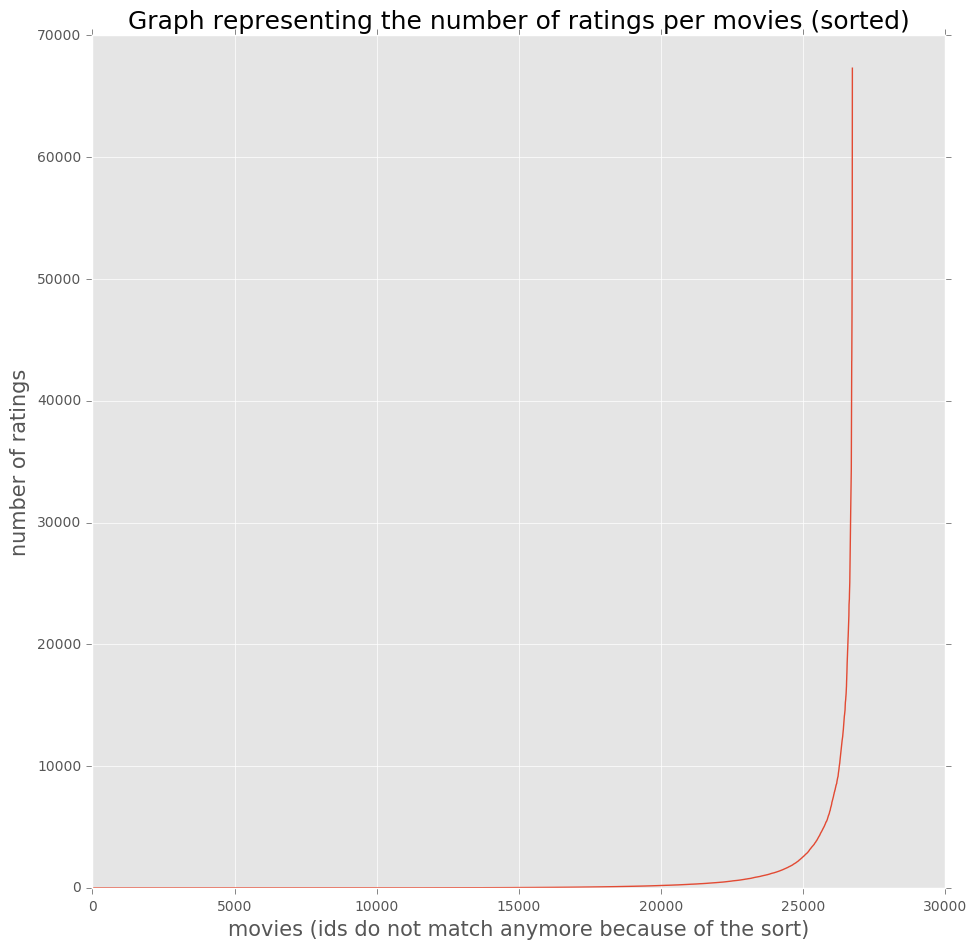

In [10]:
sorted_plot(nb_rating_foreach_movie, "movies")

###### Rating distribution : 

We see that the majority of users rated only a few films and a little group of users rated an enormous amount of films.

The same applies for the movies :
We see that the majority of movies has only been rated a few times, while a little group of films (the most known ones) has bee rated thousands of times.

### My ratings

In [10]:
%run rate-movies.py

Please rate the following movies.
1 (worst) -- 5 (best), or 0 if not seen

Toy Story (1995)
Adventure, Animation, Children, Comedy, Fantasy
your rating: 4

Independence Day (1996)
Action, Adventure, Sci-Fi, Thriller
your rating: 0

Dances with Wolves (1990)
Adventure, Drama, Western
your rating: 0

Star Wars: Episode VI - Return of the Jedi (1983)
Action, Adventure, Sci-Fi
your rating: 3

Mission: Impossible (1996)
Action, Adventure, Mystery, Thriller
your rating: 3

Ace Ventura: Pet Detective (1994)
Comedy
your rating: 0

Die Hard: With a Vengeance (1995)
Action, Crime, Thriller
your rating: 0

Batman Forever (1995)
Action, Adventure, Comedy, Crime
your rating: 1

Pretty Woman (1990)
Comedy, Romance
your rating: 4

Men in Black (1997)
Action, Comedy, Sci-Fi
your rating: 4

Dumb & Dumber (1994)
Adventure, Comedy
your rating: 4

Successfully saved 7 ratings in `my-ratings.txt`
Your user ID: 138494


### 3.5 Partitionning the dataset

###### First we create a list of dict with our txt file

In [181]:
file = open("my-ratings.txt")
to_be_added = []


for line in file :
    to_be_added.append(json.loads(line))
file.close()

###### Then we add it to our RDD

In [182]:
additional = sc.parallelize(to_be_added)

combined = data.union(additional)

###### Now we split in in training and test sets

In [183]:
#Elements of our RDD are dictionaries
def training_set(dico): return (dico['timestamp'] % 10) < 8

def testing_set(dico): return not (training_set(dico))


training = combined.filter(training_set)
testing = combined.filter(testing_set)

###### We create usefull lists (Those are built from the training RDD,   NOT the entire data RDD) :


In [184]:
elements = training.map(itemgetter("movieId", "userId", "timestamp", "rating")).collect()

In [185]:
rating_list = np.array(training.map(itemgetter("rating")).collect())

In [186]:
user_list = np.array(training.map(itemgetter("userId")).collect())

In [187]:
movie_list = np.array(training.map(itemgetter("movieId")).collect())

In [188]:
# unique_users contains all users in a sorted order and only once

# user_first_appearance_in_elem contains the index of the first occurence of any user in the starting array 'elements'
# => retrieve the global shape of 'elements' from unique_users

# nb_rating_foreach_user is explicit

unique_users, user_first_appearance_in_elem, nb_rating_foreach_user = np.unique(user_list,
                                                                                return_index = True,
                                                                                return_counts = True)

In [189]:
# unique_movies contains all movies in a sorted order and only once

# nb_rating_foreach_user is explicit

unique_movies, nb_rating_foreach_movie = np.unique(movie_list, return_counts = True)

###### We also create usefull dictionaries :

Please note that :
- UUI = Unique User Idex = index of this user in 'unique_users' array
- UMI = Unique Movie Idex = index of this movie in 'unique_movies' array

In [190]:
UUI_2_userID = dict(enumerate(unique_users))

userID_2_UUI = {v: k for k, v in UUI_2_userID.items()}

In [191]:
UMI_2_movieID = dict(enumerate(unique_movies))

movieID_2_UMI = {v: k for k, v in UMI_2_movieID.items()}

In [192]:
tuple_2_rating = {(movie, user):rating for movie,user,t,rating in elements}

###### And some length constants

In [193]:
len_elem = len(elements)
len_u = len(unique_users)
len_m = len(unique_movies)

## 3.2.1 Baseline recommender system

### 3.6 Baseline model

In [194]:
mean = np.mean(rating_list)

---

To build alphas[] we need to iterate over all unique_users and over all the movies they have rated. The latter task is simple because in 'elements' the data is ordered by user (which justifies the j-for-loop)

In [195]:
alphas = []

# For all users
for i in range (len_u) :
    
    # The number of ratings of our user
    Nu = nb_rating_foreach_user[i]
    
    # The id of our user
    u_id = unique_users[i] 
    
    # Index of the first apperance of this user
    ufa = user_first_appearance_in_elem[i]
    
    sum_rum = 0;
    
    # Iterate over every ratings of our user
    for j in range (Nu):      
        sum_rum += elements[ufa + j][RATING] - mean
            
    
    temp_alpha = sum_rum/float(Nu)
    alphas.append(temp_alpha)
    
    print_state(i, 30, len_u)
    
print("\r 100 %")

 100 %


In [196]:
'''We now append a last value to handle the case when a user in 'testing' has no UUI '''

ACCESS_DEFAULT_ALPHA = len_u

alphas.append(np.mean(alphas))

---
Computing the betas[] is a bit more complicated because for one movie, all the ratings are not grouped together as the users were. Iterating over all the 'elements' array     *#movies*   times is way to long !

So we must create a list linking any unique movie with the list of all users_id that have rated it.
=> We iterate over 'elements' only once !

In [197]:
'''WARNING : This must be accessed with Unique Movie Index'''
all_users_related_to_movie = [None] * len_m

for UMI in range (len_m) :
    all_users_related_to_movie[UMI] = []
    
for i in range (len_elem) :
    
    e = elements[i]
    
    # UMI = Unique Movie Index
    UMI = movieID_2_UMI[ e[MOVIE] ]
    
    all_users_related_to_movie[UMI].append( e[USER] )

    print_state(i, 30, len_elem)
    
print("\r 100 %")

 100 %


Now we can compute the item bias for each movie :

For each movie :
- access all the users that rated it thanks to the array 'all_users_related_to_movie'
- access the rating of this user about this film with the dictionary 'tuple_2_rating'
- access to the alpha value of this user thanks to the dictionary userID_2_UUI

- Compute the beta value and append it to betas[]

In [198]:
betas = []

# For all movies (Unique Movie Index)
for UMI in range (len_m) :
    
    # The number of ratings of our movie
    Nm = nb_rating_foreach_movie[UMI]
    
    # The id of our movie in the 'unique_movie' array
    m_id = unique_movies[UMI]
    
    # Beware ! Those are userID !
    linked_users = all_users_related_to_movie[UMI]
    
    
    # To be computed
    sum_rum = 0
        
    for u in linked_users:
        
        # Recall : alphas are ordered in the same way as unique_user (alphas[k] is for unique_user[k])
        # So in order to find alpha_u, we need to :
                
        # - use our previously computed dictionary to take the UUI of this user
        
        # - access alphas with this UUI
        
        UUI = userID_2_UUI[u]
        
        alpha_u = alphas[UUI]
        
        rating = tuple_2_rating.get((m_id, u), mean) # The second argument is the default value in case the rating does not exist

        sum_rum += rating - mean - alpha_u
    
    
    temp_beta = sum_rum/float(Nm)
    betas.append(temp_beta)
    
    print_state(UMI , 2, len_m)

print("\r 100 %")

 100 %


In [199]:
'''We now append a last value to handle the case when a movie in 'testing' has no UMI '''

ACCESS_DEFAULT_BETA = len_m

betas.append(np.mean(betas))

----

###### Now we load the test_elements

In [200]:
test_elements = testing.map(itemgetter("movieId", "userId", "timestamp", "rating")).collect()

In [201]:
len_test = len(test_elements)

In [202]:
# The real values of the ratings, in order to do a comparison with our estimations
tuple_2_true_value = {(movie, user):rating for movie,user,t,rating in test_elements}

In [203]:
# Needed to iterate over all user_ID in error()
users_test = np.array(testing.map(itemgetter("userId")).collect())

# Needed to get Nu and to get all the movies related to a user in error()
unique_test_users, user_first_appearance_in_test, nb_test_rating_foreach_user = np.unique(users_test,
                                                                                         return_index = True,
                                                                                         return_counts = True)

In [204]:
UUI_2_userID_test = dict(enumerate(unique_test_users))
userID_2_UUI_test = {v: k for k, v in UUI_2_userID_test.items()}

---
###### We can now build a dictionary to compute our estimations

Please note that :
- Movies (resp users) that have no UMI (resp UUI) have no beta (resp alpha) value
 => We will use the default values of alpha and beta that we added 'by hand'

In [205]:
tuple_2_guess = {}

len_test = len(test_elements)

# ------- Dict building -------
keys = [None] * len_test
guess = np.zeros(len_test)

for i in range(len_test):


    # -------- Shortcuts --------
    user_id = test_elements[i][USER]
    movie_id = test_elements[i][MOVIE]

    UUI = userID_2_UUI.get(user_id, ACCESS_DEFAULT_ALPHA)
    UMI = movieID_2_UMI.get(movie_id, ACCESS_DEFAULT_BETA)


    # ----- Computing the values -----
    keys[i] = (  movie_id,  user_id  )
    guess[i] = mean + alphas[UUI] + betas[UMI]

    # ---- Creation of the pair ----
    tuple_2_guess[keys[i]] = guess[i]

    # ----- Printing the state -----
    print_state(i, 30, len_test)

print("\r 100 %")



 100 %


### 3.7 Evaluation

In [206]:
def error (guess) :
    
    """This function takes a dictionary (movieID, userID => guess) and returns the mean square error
    with respect to the true value of the ratings"""
    

    U = len(unique_test_users)
    error = 0
    
    # Access all users in this RDD
    for UUI in range (U):
        
        # Take their ID and their Nu
        user_id = unique_test_users[UUI]
        Nu = nb_test_rating_foreach_user[ UUI ]
        
        # Shortcut
        ufa = user_first_appearance_in_test[ UUI ]
        
        m_sum = 0
        
        
        # Access all movies linked to this user
        for j in range(Nu):
            
            # This is allowed because films rated by the same users are stored back-to-back
            movie_id = test_elements[ufa + j][MOVIE]
            
            # ------- Applying the formula -------
            diff = guess[movie_id, user_id] - tuple_2_true_value[movie_id, user_id]
            m_sum += diff*diff
        
        error += np.sqrt(m_sum/float(Nu))

    return error/float(U)   

In [207]:
print("The observed error is : ", error(tuple_2_guess))

The observed error is :  0.866910321527


## 3.2.2 Matrix-factorization model

### 3.8 Regularization

In [47]:
"Petit test pour voir comment fonctionne np.unique"

a = [4, -1, 64, 5, 18, 13, 18, 2, 91, 3]

unique, ix, inv, nb = np.unique(a, return_index = True, return_inverse = True, return_counts = True)

print("unique : ", unique)
print("indices : ", ix)
print("inverse indices : ", inv)
print("nombre : ", nb)

unique :  [-1  2  3  4  5 13 18 64 91]
indices :  [1 7 9 0 3 5 4 2 8]
inverse indices :  [3 0 7 4 6 5 6 1 8 2]
nombre :  [1 1 1 1 1 1 2 1 1]
